# The Final CNN Model We Implement


In [53]:
# Hide TF warnings
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import math


In [45]:
# Base dataset directory
BASE_DIR = "../datasets"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")

# Image and batching parameters
IMG_SIZE   = (128, 128)
BATCH_SIZE = 32
SEED       = 42

# Training data size settings (number of batches)
TRAIN_BATCH_LIMITS = [120, 240, 360, 480, 600]


In [46]:
# Load once — this scans and builds file lists
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Normalization function
def normalize_images(x, y):
    return tf.cast(x, tf.float32) / 255.0, y

AUTOTUNE = tf.data.AUTOTUNE

# Prepare full preprocessed datasets (no limit yet)
train_ds_full = (
    train_ds_raw
    .map(normalize_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds_raw
    .map(normalize_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

print("✅ Datasets loaded.")


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
✅ Datasets loaded.


In [47]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [48]:
results = []
histories = {}

for limit in TRAIN_BATCH_LIMITS:
    num_images = limit * BATCH_SIZE
    print("\n===================================")
    print(f" Training with {num_images} images (approx)")
    print("===================================")

    # ✅ Limit dataset dynamically without rescanning
    train_ds_limited = train_ds_full.take(limit)

    # Build fresh model
    model = build_model()

    # Train
    history = model.fit(
        train_ds_limited,
        validation_data=val_ds,
        epochs=10,
        verbose=1
    )

    # Record results
    best_val_acc = max(history.history['val_accuracy'])
    results.append((num_images, best_val_acc))
    histories[num_images] = history



 Training with 3840 images (approx)
Epoch 1/10


2025-11-11 19:11:20.124327: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 6291584 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-11-11 19:11:20.124575: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 6291584 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


120/120 [==============================] - 13s 30ms/step - loss: 0.7015 - accuracy: 0.5188 - val_loss: 0.6848 - val_accuracy: 0.5038
Epoch 2/10
120/120 [==============================] - 2s 16ms/step - loss: 0.6678 - accuracy: 0.5859 - val_loss: 0.6384 - val_accuracy: 0.6318
Epoch 3/10
120/120 [==============================] - 2s 15ms/step - loss: 0.6276 - accuracy: 0.6477 - val_loss: 0.5945 - val_accuracy: 0.6746
Epoch 4/10
120/120 [==============================] - 2s 15ms/step - loss: 0.5897 - accuracy: 0.6865 - val_loss: 0.5703 - val_accuracy: 0.7054
Epoch 5/10
120/120 [==============================] - 2s 15ms/step - loss: 0.5620 - accuracy: 0.7091 - val_loss: 0.5996 - val_accuracy: 0.6770
Epoch 6/10
120/120 [==============================] - 2s 15ms/step - loss: 0.5445 - accuracy: 0.7258 - val_loss: 0.5135 - val_accuracy: 0.7462
Epoch 7/10
120/120 [==============================] - 2s 15ms/step - loss: 0.5051 - accuracy: 0.7615 - val_loss: 0.5162 - val_accuracy: 0.7500
Epoch 8/1

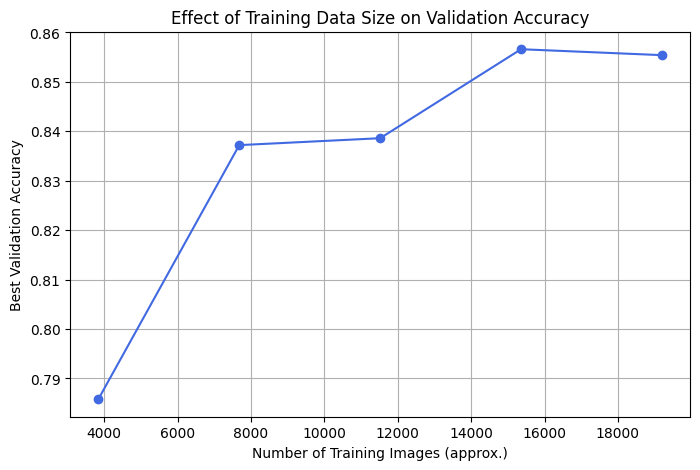

  3840 images → best val accuracy = 0.7858
  7680 images → best val accuracy = 0.8372
 11520 images → best val accuracy = 0.8386
 15360 images → best val accuracy = 0.8566
 19200 images → best val accuracy = 0.8554


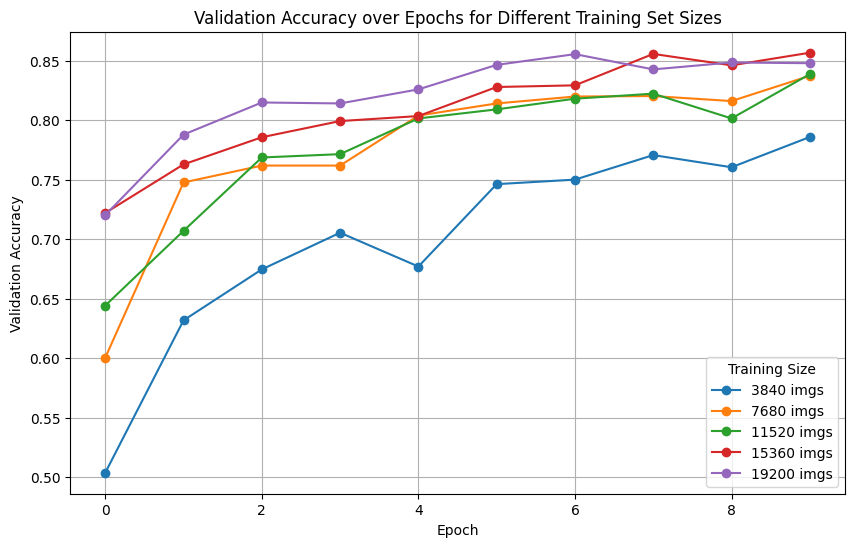

In [55]:
x_vals = [r[0] for r in results]
y_vals = [r[1] for r in results]

plt.figure(figsize=(8,5))
plt.plot(x_vals, y_vals, marker='o', color='royalblue')
plt.title("Effect of Training Data Size on Validation Accuracy")
plt.xlabel("Number of Training Images (approx.)")
plt.ylabel("Best Validation Accuracy")
plt.grid(True)
plt.show()

for n, acc in results:
    print(f"{n:>6} images → best val accuracy = {acc:.4f}")
plt.figure(figsize=(10,6))

for num_images, history in histories.items():
    plt.plot(
        history.history['val_accuracy'],
        marker='o',
        label=f'{num_images} imgs'
    )

plt.title("Validation Accuracy over Epochs for Different Training Set Sizes")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.legend(title="Training Size")
plt.show()


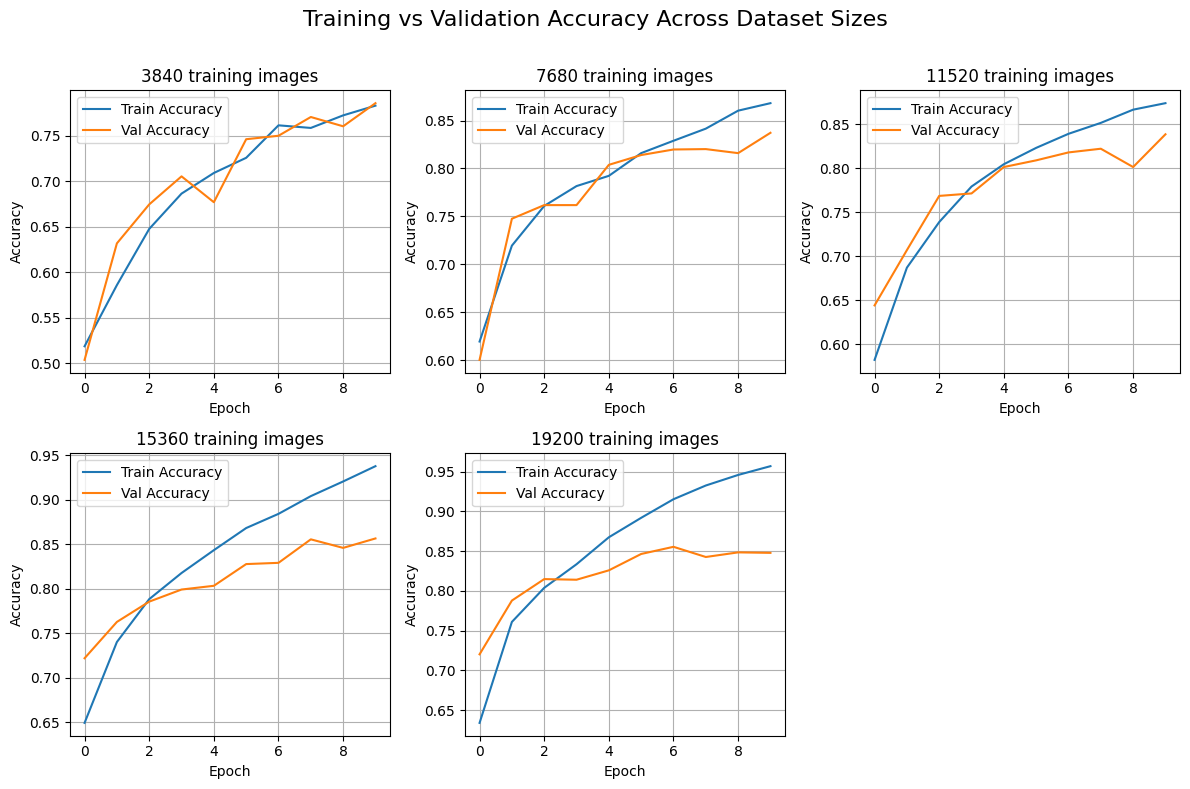

In [58]:
# Number of experiments (one per dataset size)
num_experiments = len(histories)

# Create grid for subplots
cols = 3
rows = math.ceil(num_experiments / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
axes = axes.flatten()  # flatten in case of 1D or multi-row grid

for idx, (num_images, history) in enumerate(histories.items()):
    ax = axes[idx]
    ax.plot(history.history['accuracy'], label='Train Accuracy')
    ax.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax.set_title(f"{num_images} training images")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.grid(True)
    ax.legend()

# Hide any empty subplots (if #experiments not multiple of cols)
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Training vs Validation Accuracy Across Dataset Sizes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In the above section we used a basic model with default learning rate and no image agumentation. We set up 5 limits of batch sizes, corresponding to 4k, 8k, 12k 16k and 20k images to train with the same model, all using 10 epoches. In this section we mainly explore the effect of different amount of data.

The results reconfirms that increasing amount of data will increase accuracy and 10 epoches will not have overfitting problem yet, as all plots shows that the validation accuracy did not start to decrease at final epoch.

With this conclusion, we start to improve our model and image agumentation to try to improve the accuracy.

We have selected the data amount to be at about 15k images, as we notice that the increase from 15k images to 20k images used does not result in noticable improvement in accuracy. Also considerable time was spent on .shuffle(1000) function, we decided to reduce this to 200 as this cat vs dog problem will not be muchly dependent on the randomness of data and reducing this amount of images in shuffling dramatically reduce startup time.

Thus we can balance the deminishing return from increase in dataset size with the amount of time required for training.